# Purpose:
- To analyze the results from online motion correction.
- Compare zdrift calculation (from slurm batch jobs) with the logs

In [31]:
from pathlib import Path
from glob import glob
import h5py
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os

In [3]:
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_746542\1402862265')

Text(0.5, 1.0, '10/30/2024 Test #9')

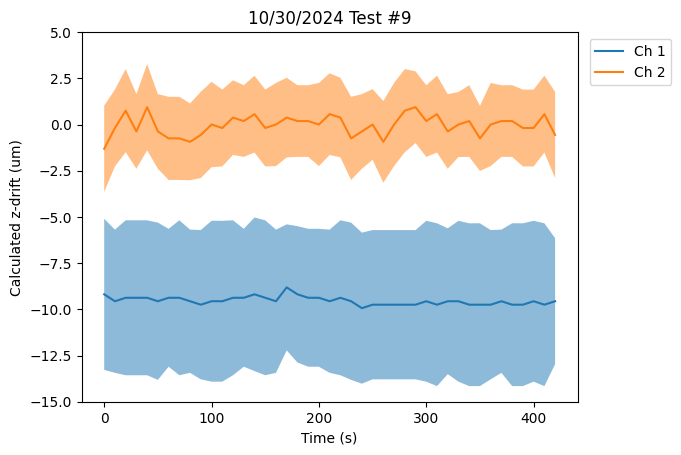

In [201]:
test_ind = 9
ylims = [-15, 5]
zdrift_fn_list = glob(str(data_dir / f'*_timeseries_{test_ind:05}_*_zdrift.h5'))
ch1_drift = []
ch2_drift = []
for zi in range(len(zdrift_fn_list)):
    zdrift_fn = zdrift_fn_list[zi]
    with h5py.File(zdrift_fn, 'r') as h:
        matched_inds = h['matched_inds'][:]
    if zi % 2 == 0:
        ch1_drift.append(matched_inds)
    else:
        ch2_drift.append(matched_inds)
ch1_drift_um = (40 - np.array(ch1_drift)) * 0.75
ch2_drift_um = (40 - np.array(ch2_drift)) * 0.75
timepoints = np.arange(len(ch1_drift[0])) * 10

fig, ax = plt.subplots()
ax.plot(timepoints, np.mean(ch1_drift_um, axis=0), label='Ch 1')
ax.plot(timepoints, np.mean(ch2_drift_um, axis=0), label='Ch 2')
ax.fill_between(timepoints, np.mean(ch1_drift_um, axis=0) - np.std(ch1_drift_um, axis=0),
                np.mean(ch1_drift_um, axis=0) + np.std(ch1_drift_um, axis=0), alpha=0.5)
ax.fill_between(timepoints, np.mean(ch2_drift_um, axis=0) - np.std(ch2_drift_um, axis=0),
                np.mean(ch2_drift_um, axis=0) + np.std(ch2_drift_um, axis=0), alpha=0.5)
# ax.axhline(40, color='k', linestyle='--')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Calculated z-drift (um)')
ax.set_ylim(ylims[0], ylims[1])
ax.set_title(f'10/30/2024 Test #{test_ind}')

In [202]:
# test_ind = 11
estimation_csv = glob(str(data_dir / f'*_timeseries_Motion_{test_ind:05}.csv'))[0]
estimation_log = pd.read_csv(estimation_csv)
correction_csv = glob(str(data_dir / f'*_timeseries_Motion_Corrected_{test_ind:05}.csv'))[0]
correction_log = pd.read_csv(correction_csv)

# assert ch1 and ch2 pairs saved in separate rows
assert np.array_equal(estimation_log.iloc[::2].timestamp.values, estimation_log.iloc[1::2].timestamp.values)
assert np.array_equal(estimation_log.iloc[::2][' frameNumber'].values, estimation_log.iloc[1::2][' frameNumber'].values)
assert np.array_equal(estimation_log.iloc[::2][' roiName'].values, estimation_log.iloc[1::2][' roiName'].values)
assert np.array_equal(estimation_log.iloc[::2][' z'].values, estimation_log.iloc[1::2][' z'].values)
ch1_inds = estimation_log.iloc[::2].index
ch2_inds = estimation_log.iloc[1::2].index
estimation_log.loc[ch1_inds, 'channel'] = int(1)
estimation_log.loc[ch2_inds, 'channel'] = int(2)
estimation_log.channel = estimation_log.channel.astype(int)

estimation_log['drPix_x'] = estimation_log[' drPixel'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[0]))
estimation_log['drPix_y'] = estimation_log[' drPixel'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[1]))
estimation_log['drPix_z'] = estimation_log[' drPixel'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[2]))
estimation_log['dr_x'] = estimation_log[' drRef'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[0]))
estimation_log['dr_y'] = estimation_log[' drRef'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[1]))

correction_log['dr_x'] = correction_log[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[0]))
correction_log['dr_y'] = correction_log[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[1]))
correction_log['dr_z_ch1'] = correction_log[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[2]))
correction_log['dr_z_ch2'] = correction_log[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[3]))
deg_to_pix = 200.95999997
correction_log['drPix_x'] = correction_log['dr_x'] * deg_to_pix
correction_log['drPix_y'] = correction_log['dr_y'] * deg_to_pix

In [165]:
def smooth_and_interpolate(estimation_df, smooth_len='10s'):
    timestamps = estimation_df.timestamp.values
    estimation_df.set_index('timestamp', inplace=True)
    estimation_df.index = pd.to_datetime(estimation_df.index, unit='s')

    # rolling average of 10 seconds, based on the timestamp, for drPix_x, drPix_y, and drPix_z
    estimation_df['drPix_x_smooth'] = estimation_df.drPix_x.rolling(smooth_len).mean()
    estimation_df['drPix_y_smooth'] = estimation_df.drPix_y.rolling(smooth_len).mean()
    estimation_df['drPix_z_smooth'] = estimation_df.drPix_z.rolling(smooth_len).mean()

    estimation_df = estimation_df[['drPix_x_smooth', 'drPix_y_smooth', 'drPix_z_smooth']].copy()
    estimation_df.index = timestamps

    new_timestamps = np.arange(timestamps[0], round(timestamps[-1]), 1).astype(int)
    # interpolate to new_timestamps
    est_interp = estimation_df.reindex(new_timestamps, method='nearest').interpolate()
    est_interp.index.name = 'timestamp'
    est_interp.reset_index(inplace=True)
    return est_interp

In [203]:
smooth_len = '10s'
estimation_interpolated = pd.DataFrame()
for chi, ch in enumerate(range(1, 3)):
    channel_log = estimation_log[estimation_log.channel == ch]
    for zi, z in enumerate(estimation_log[' z'].unique()):
        temp_log = channel_log[channel_log[' z'] == z].copy()
        est_interp = smooth_and_interpolate(temp_log, smooth_len)
        est_interp['channel'] = ch
        est_interp['z'] = z
        estimation_interpolated = pd.concat([estimation_interpolated, est_interp])
estimation_interpolated['z'] = estimation_interpolated['z'].astype(int)
estimation_interpolated.reset_index(inplace=True, drop=True)


Text(0.5, 1.0, '10/30/2024 Test #9')

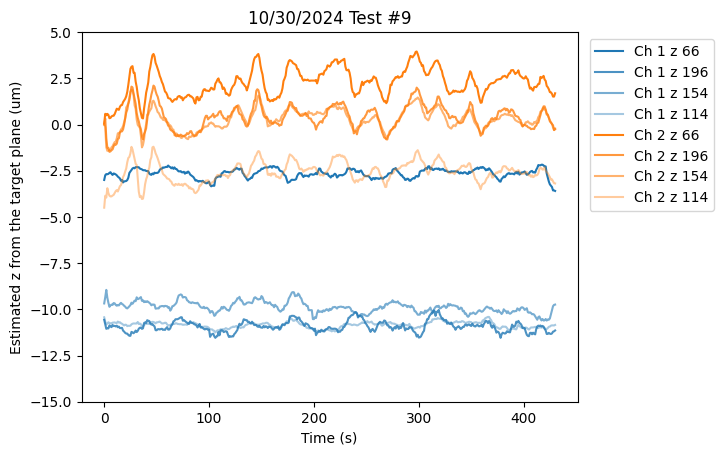

In [204]:

fig, ax = plt.subplots()
for ch in estimation_interpolated.channel.unique():
    for zi, z in enumerate(estimation_interpolated.z.unique()):
        temp_df = estimation_interpolated[(estimation_interpolated.channel == ch) & (estimation_interpolated.z == z)]
        ax.plot(temp_df.timestamp, temp_df.drPix_z_smooth, color=f'C{ch-1}', alpha=1-zi/5, label=f'Ch {ch} z {z}')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Estimated z from the target plane (um)')
ax.set_ylim(ylims[0], ylims[1])
ax.set_title(f'10/30/2024 Test #{test_ind}')

Text(0.5, 1.0, '10/30/2024 Test #9')

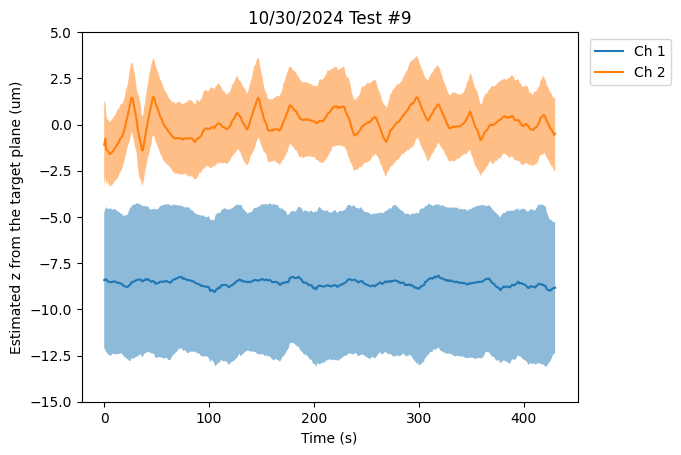

In [205]:
fig, ax = plt.subplots()
for ch in estimation_interpolated.channel.unique():
    temp_df = estimation_interpolated[estimation_interpolated.channel == ch]
    averaged_est = temp_df.groupby('timestamp').mean()
    std_est = temp_df.groupby('timestamp').std()
    ax.fill_between(averaged_est.index, averaged_est.drPix_z_smooth - std_est.drPix_z_smooth,
                    averaged_est.drPix_z_smooth + std_est.drPix_z_smooth, alpha=0.5)
    ax.plot(averaged_est.index, averaged_est.drPix_z_smooth, label=f'Ch {ch}')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Estimated z from the target plane (um)')
ax.set_ylim(ylims[0], ylims[1])
ax.set_title(f'10/30/2024 Test #{test_ind}')

Text(0.5, 1.0, '10/30/2024 Test #11 - Correction log')

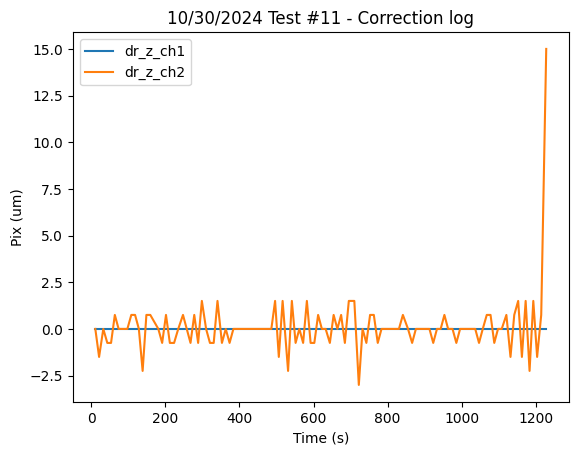

In [197]:
fig, ax = plt.subplots()

# correction_log.plot(x='timestamp', y='drPix_x', ax=ax)
# correction_log.plot(x='timestamp', y='drPix_y', ax=ax)
correction_log.plot(x='timestamp', y='dr_z_ch1', ax=ax)
correction_log.plot(x='timestamp', y='dr_z_ch2', ax=ax)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pix (um)')
ax.set_title(f'10/30/2024 Test #{test_ind} - Correction log')

# From 11/06/2024
- now with helper functions

In [207]:
def get_logs(data_dir, test_ind):
    estimation_csv = glob(str(data_dir / f'*_timeseries_Motion_{test_ind:05}.csv'))[0]
    estimation_log = pd.read_csv(estimation_csv)
    correction_csv = glob(str(data_dir / f'*_timeseries_Motion_Corrected_{test_ind:05}.csv'))[0]
    correction_log = pd.read_csv(correction_csv)

    # assert ch1 and ch2 pairs saved in separate rows
    assert np.array_equal(estimation_log.iloc[::2].timestamp.values, estimation_log.iloc[1::2].timestamp.values)
    assert np.array_equal(estimation_log.iloc[::2][' frameNumber'].values, estimation_log.iloc[1::2][' frameNumber'].values)
    assert np.array_equal(estimation_log.iloc[::2][' roiName'].values, estimation_log.iloc[1::2][' roiName'].values)
    assert np.array_equal(estimation_log.iloc[::2][' z'].values, estimation_log.iloc[1::2][' z'].values)
    ch1_inds = estimation_log.iloc[::2].index
    ch2_inds = estimation_log.iloc[1::2].index
    estimation_log.loc[ch1_inds, 'channel'] = int(1)
    estimation_log.loc[ch2_inds, 'channel'] = int(2)
    estimation_log.channel = estimation_log.channel.astype(int)

    estimation_log['drPix_x'] = estimation_log[' drPixel'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[0]))
    estimation_log['drPix_y'] = estimation_log[' drPixel'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[1]))
    estimation_log['drPix_z'] = estimation_log[' drPixel'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[2]))
    estimation_log['dr_x'] = estimation_log[' drRef'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[0]))
    estimation_log['dr_y'] = estimation_log[' drRef'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[1]))

    correction_log['dr_x'] = correction_log[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[0]))
    correction_log['dr_y'] = correction_log[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[1]))
    correction_log['dr_z_ch1'] = correction_log[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[2]))
    correction_log['dr_z_ch2'] = correction_log[' dr'].apply(lambda x: float(x.split('[')[1].split(']')[0].split(' ')[3]))
    deg_to_pix = 200.95999997
    correction_log['drPix_x'] = correction_log['dr_x'] * deg_to_pix
    correction_log['drPix_y'] = correction_log['dr_y'] * deg_to_pix
    return estimation_log, correction_log


def get_interpolated_estimation_log(estimation_log, smooth_len='10s'):
    estimation_interpolated = pd.DataFrame()
    for chi, ch in enumerate(range(1, 3)):
        channel_log = estimation_log[estimation_log.channel == ch]
        for zi, z in enumerate(estimation_log[' z'].unique()):
            temp_log = channel_log[channel_log[' z'] == z].copy()
            est_interp = smooth_and_interpolate(temp_log, smooth_len)
            est_interp['channel'] = ch
            est_interp['z'] = z
            estimation_interpolated = pd.concat([estimation_interpolated, est_interp])
    estimation_interpolated['z'] = estimation_interpolated['z'].astype(int)
    estimation_interpolated.reset_index(inplace=True, drop=True)
    return estimation_interpolated


def smooth_and_interpolate(estimation_df, smooth_len='10s'):
    timestamps = estimation_df.timestamp.values
    estimation_df.set_index('timestamp', inplace=True)
    estimation_df.index = pd.to_datetime(estimation_df.index, unit='s')

    # rolling average of 10 seconds, based on the timestamp, for drPix_x, drPix_y, and drPix_z
    estimation_df['drPix_x_smooth'] = estimation_df.drPix_x.rolling(smooth_len).mean()
    estimation_df['drPix_y_smooth'] = estimation_df.drPix_y.rolling(smooth_len).mean()
    estimation_df['drPix_z_smooth'] = estimation_df.drPix_z.rolling(smooth_len).mean()

    estimation_df = estimation_df[['drPix_x_smooth', 'drPix_y_smooth', 'drPix_z_smooth']].copy()
    estimation_df.index = timestamps

    new_timestamps = np.arange(timestamps[0], round(timestamps[-1]), 1).astype(int)
    # interpolate to new_timestamps
    est_interp = estimation_df.reindex(new_timestamps, method='nearest').interpolate()
    est_interp.index.name = 'timestamp'
    est_interp.reset_index(inplace=True)
    return est_interp


def get_zdrift_from_h5(data_dir, test_ind):
    zdrift_fn_list = glob(str(data_dir / f'*_timeseries_{test_ind:05}_*_zdrift.h5'))
    ch1_drift = []
    ch2_drift = []
    for zi in range(len(zdrift_fn_list)):
        zdrift_fn = zdrift_fn_list[zi]
        with h5py.File(zdrift_fn, 'r') as h:
            matched_inds = h['matched_inds'][:]
        if zi % 2 == 0:
            ch1_drift.append(matched_inds)
        else:
            ch2_drift.append(matched_inds)
    ch1_drift_um = (40 - np.array(ch1_drift)) * 0.75
    ch2_drift_um = (40 - np.array(ch2_drift)) * 0.75
    timepoints = np.arange(len(ch1_drift[0])) * 10
    return ch1_drift_um, ch2_drift_um, timepoints

In [231]:
# 1x2 config
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_746542\1403914421')

In [232]:
test_ind = 1
estimation_log, correction_log = get_logs(data_dir, test_ind)
estimation_interpolated = get_interpolated_estimation_log(estimation_log)
ch1_drift_um, ch2_drift_um, timepoints = get_zdrift_from_h5(data_dir, test_ind)

Text(0.5, 0.98, '11/06/2024 1x2 Test')

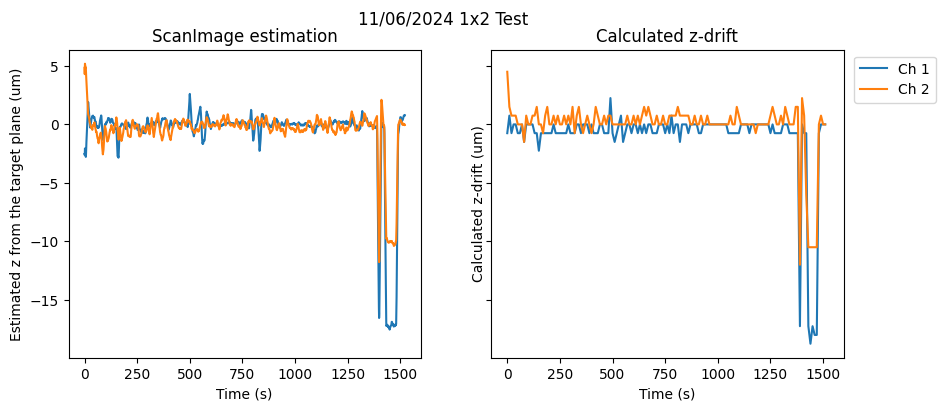

In [233]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True, sharex=True)

for ch in estimation_interpolated.channel.unique():
    temp_df = estimation_interpolated[estimation_interpolated.channel == ch]
    averaged_est = temp_df.groupby('timestamp').mean()
    std_est = temp_df.groupby('timestamp').std()
    ax[0].fill_between(averaged_est.index, averaged_est.drPix_z_smooth - std_est.drPix_z_smooth,
                    averaged_est.drPix_z_smooth + std_est.drPix_z_smooth, alpha=0.5)
    ax[0].plot(averaged_est.index, averaged_est.drPix_z_smooth, label=f'Ch {ch}')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Estimated z from the target plane (um)')
ax[0].set_title(f'ScanImage estimation')

ax[1].plot(timepoints, np.mean(ch1_drift_um, axis=0), label='Ch 1')
ax[1].plot(timepoints, np.mean(ch2_drift_um, axis=0), label='Ch 2')
ax[1].fill_between(timepoints, np.mean(ch1_drift_um, axis=0) - np.std(ch1_drift_um, axis=0),
                np.mean(ch1_drift_um, axis=0) + np.std(ch1_drift_um, axis=0), alpha=0.5)
ax[1].fill_between(timepoints, np.mean(ch2_drift_um, axis=0) - np.std(ch2_drift_um, axis=0),
                np.mean(ch2_drift_um, axis=0) + np.std(ch2_drift_um, axis=0), alpha=0.5)
# ax.axhline(40, color='k', linestyle='--')
ax[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1))
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Calculated z-drift (um)')
# ax.set_ylim(ylims[0], ylims[1])
ax[1].set_title(f'Calculated z-drift')

fig.suptitle(f'11/06/2024 1x2 Test')

Text(0.5, 0.98, '11/06/2024 1x2 Test')

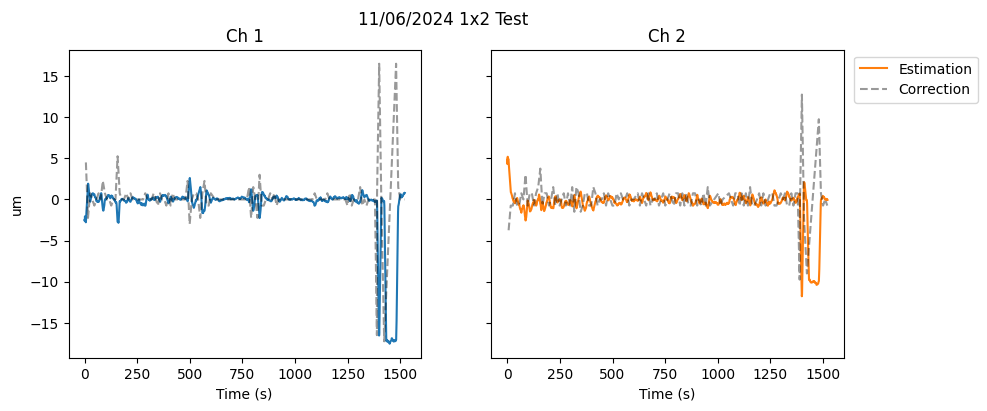

In [256]:
# show correction log
# along with the estimation log
# per channel
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True, sharex=True)
for axi, ch in enumerate(estimation_interpolated.channel.unique()):
    temp_df = estimation_interpolated[estimation_interpolated.channel == ch]
    averaged_est = temp_df.groupby('timestamp').mean()
    std_est = temp_df.groupby('timestamp').std()
    ax[axi].fill_between(averaged_est.index, averaged_est.drPix_z_smooth - std_est.drPix_z_smooth,
                    averaged_est.drPix_z_smooth + std_est.drPix_z_smooth, color=f'C{ch-1}', alpha=0.5)
    ax[axi].plot(averaged_est.index, averaged_est.drPix_z_smooth, color=f'C{ch-1}', label='Estimation')
    ax[axi].plot(correction_log.timestamp, -correction_log[f'dr_z_ch{ch}'], color='k', linestyle='--', label='Correction', alpha=0.4)
    ax[axi].set_title(f'Ch {ch}')
    ax[axi].set_xlabel('Time (s)')
ax[0].set_ylabel('um')
ax[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1))
fig.suptitle(f'11/06/2024 1x2 Test')

Text(0.5, 0.98, '11/06/2024 1x2 Test')

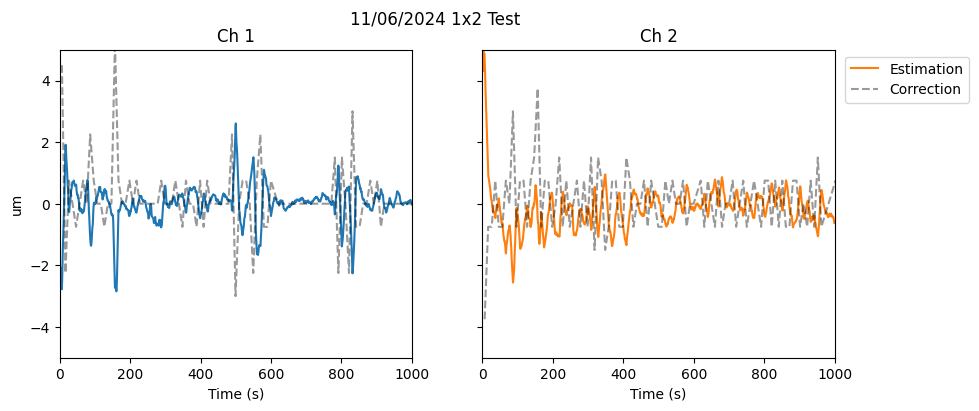

In [257]:
# show correction log
# along with the estimation log
# per channel
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True, sharex=True)
for axi, ch in enumerate(estimation_interpolated.channel.unique()):
    temp_df = estimation_interpolated[estimation_interpolated.channel == ch]
    averaged_est = temp_df.groupby('timestamp').mean()
    std_est = temp_df.groupby('timestamp').std()
    ax[axi].fill_between(averaged_est.index, averaged_est.drPix_z_smooth - std_est.drPix_z_smooth,
                    averaged_est.drPix_z_smooth + std_est.drPix_z_smooth, color=f'C{ch-1}', alpha=0.5)
    ax[axi].plot(averaged_est.index, averaged_est.drPix_z_smooth, color=f'C{ch-1}', label='Estimation')
    ax[axi].plot(correction_log.timestamp, -correction_log[f'dr_z_ch{ch}'], color='k', linestyle='--', label='Correction', alpha=0.4)
    ax[axi].set_title(f'Ch {ch}')
    ax[axi].set_xlabel('Time (s)')
    ax[axi].set_xlim(0, 1000)
    ax[axi].set_ylim(-5, 5)
ax[0].set_ylabel('um')
ax[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1))
fig.suptitle(f'11/06/2024 1x2 Test')

In [261]:
# 1x8 config
data_dir = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\online_motion_correction\mouse_746542\1403920410')


In [272]:
test_ind = 3
estimation_log, correction_log = get_logs(data_dir, test_ind)
estimation_interpolated = get_interpolated_estimation_log(estimation_log)
ch1_drift_um, ch2_drift_um, timepoints = get_zdrift_from_h5(data_dir, test_ind)

Text(0.5, 0.98, '11/06/2024 1x8 Test #3')

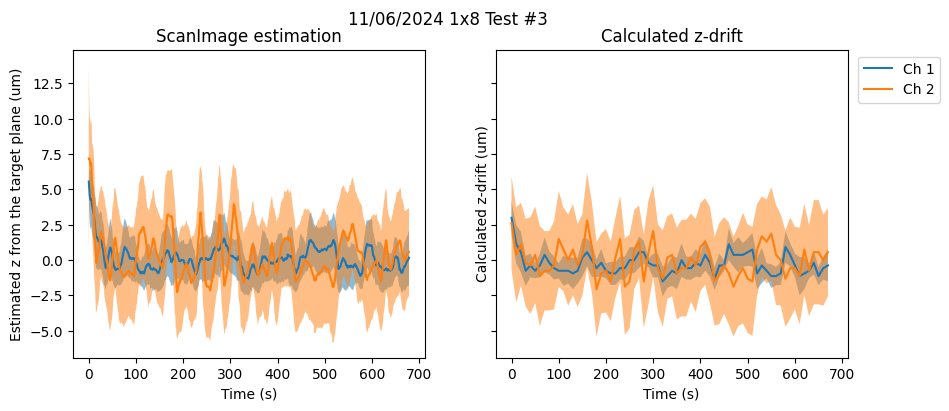

In [273]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True, sharex=True)

for ch in estimation_interpolated.channel.unique():
    temp_df = estimation_interpolated[estimation_interpolated.channel == ch]
    averaged_est = temp_df.groupby('timestamp').mean()
    std_est = temp_df.groupby('timestamp').std()
    ax[0].fill_between(averaged_est.index, averaged_est.drPix_z_smooth - std_est.drPix_z_smooth,
                    averaged_est.drPix_z_smooth + std_est.drPix_z_smooth, alpha=0.5)
    ax[0].plot(averaged_est.index, averaged_est.drPix_z_smooth, label=f'Ch {ch}')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Estimated z from the target plane (um)')
ax[0].set_title(f'ScanImage estimation')

ax[1].plot(timepoints, np.mean(ch1_drift_um, axis=0), label='Ch 1')
ax[1].plot(timepoints, np.mean(ch2_drift_um, axis=0), label='Ch 2')
ax[1].fill_between(timepoints, np.mean(ch1_drift_um, axis=0) - np.std(ch1_drift_um, axis=0),
                np.mean(ch1_drift_um, axis=0) + np.std(ch1_drift_um, axis=0), alpha=0.5)
ax[1].fill_between(timepoints, np.mean(ch2_drift_um, axis=0) - np.std(ch2_drift_um, axis=0),
                np.mean(ch2_drift_um, axis=0) + np.std(ch2_drift_um, axis=0), alpha=0.5)
# ax.axhline(40, color='k', linestyle='--')
ax[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1))
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Calculated z-drift (um)')
# ax.set_ylim(ylims[0], ylims[1])
ax[1].set_title(f'Calculated z-drift')

fig.suptitle(f'11/06/2024 1x8 Test #{test_ind}')

Text(0.5, 0.98, '11/06/2024 1x8 Test #3')

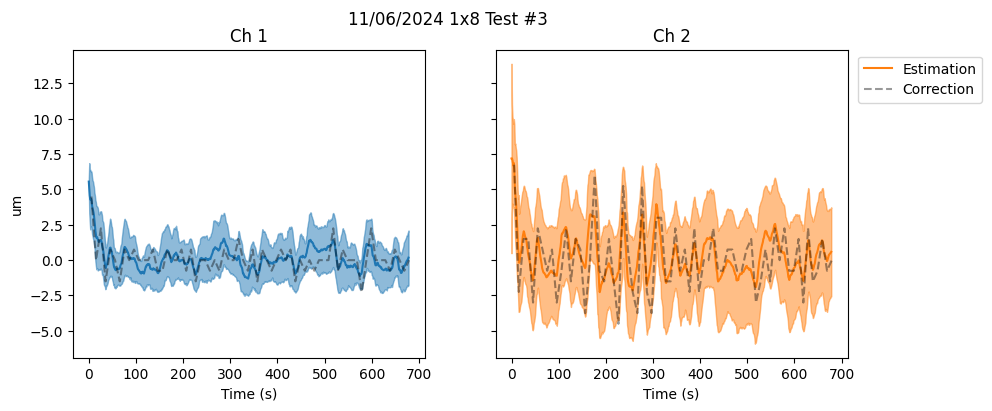

In [274]:
# show correction log
# along with the estimation log
# per channel
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True, sharex=True)
for axi, ch in enumerate(estimation_interpolated.channel.unique()):
    temp_df = estimation_interpolated[estimation_interpolated.channel == ch]
    averaged_est = temp_df.groupby('timestamp').mean()
    std_est = temp_df.groupby('timestamp').std()
    ax[axi].fill_between(averaged_est.index, averaged_est.drPix_z_smooth - std_est.drPix_z_smooth,
                    averaged_est.drPix_z_smooth + std_est.drPix_z_smooth, color=f'C{ch-1}', alpha=0.5)
    ax[axi].plot(averaged_est.index, averaged_est.drPix_z_smooth, color=f'C{ch-1}', label='Estimation')
    ax[axi].plot(correction_log.timestamp, correction_log[f'dr_z_ch{ch}'], color='k', linestyle='--', label='Correction', alpha=0.4)
    ax[axi].set_title(f'Ch {ch}')
    ax[axi].set_xlabel('Time (s)')
ax[0].set_ylabel('um')
ax[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1))
fig.suptitle(f'11/06/2024 1x8 Test #{test_ind}')

Text(0.5, 1.0, '11/06/2024 1x8 Test #3')

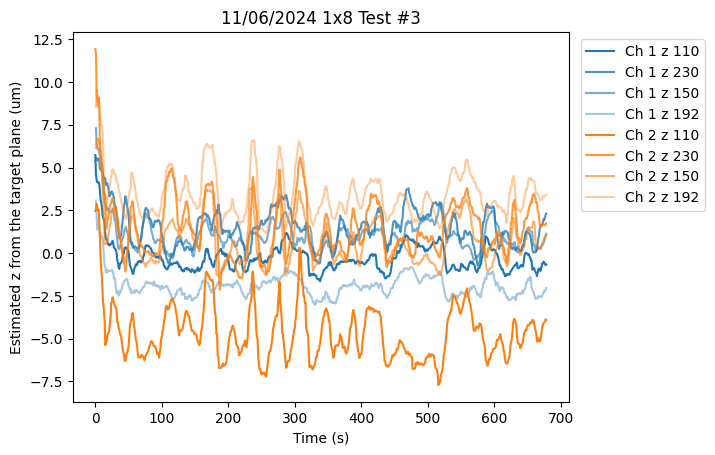

In [230]:
# Individual planes
fig, ax = plt.subplots()
for ch in estimation_interpolated.channel.unique():
    for zi, z in enumerate(estimation_interpolated.z.unique()):
        temp_df = estimation_interpolated[(estimation_interpolated.channel == ch) & (estimation_interpolated.z == z)]
        ax.plot(temp_df.timestamp, temp_df.drPix_z_smooth, color=f'C{ch-1}', alpha=1-zi/5, label=f'Ch {ch} z {z}')
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
ax.set_xlabel('Time (s)')
ax.set_ylabel('Estimated z from the target plane (um)')
ax.set_title(f'11/06/2024 1x8 Test #{test_ind}')